In [1]:
%matplotlib inline

#ignoring warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import load_model

import os

In [2]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "disease/disease/maize-dataset",
    seed=85,
    # To randomly shuffle all the images
    shuffle=True,
    # Input image size
    image_size=(256, 256),
    # Set batch size to 32
    batch_size=32
)

Found 4188 files belonging to 4 classes.


In [3]:
classes = dataset.class_names
classes

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

(32, 256, 256, 3)
[3 3 0 3 2 0 2 0 0 0 1 0 1 1 1 0 2 0 3 0 3 3 0 3 0 0 1 3 1 3 1 1]


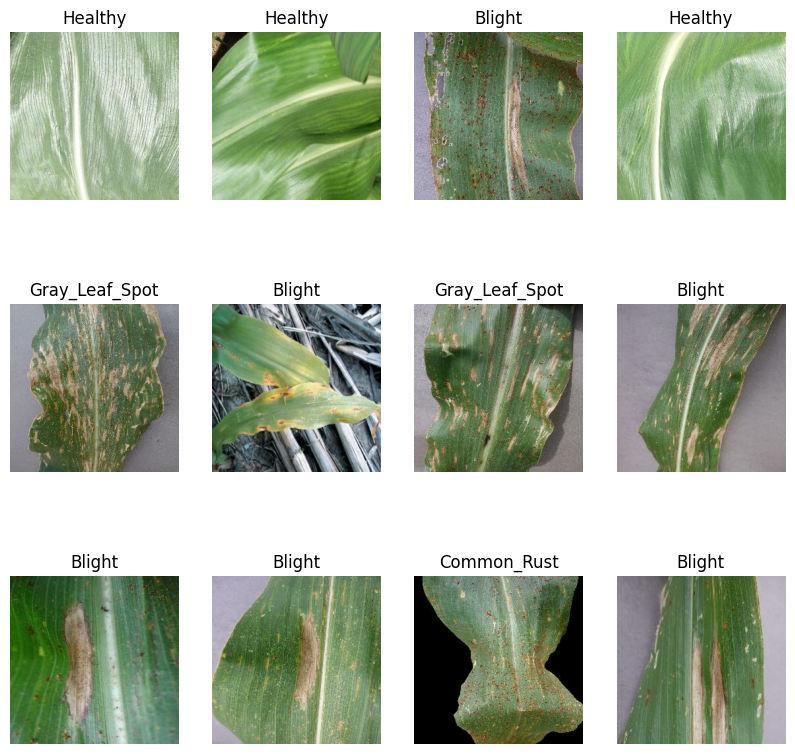

In [4]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(classes[label_batch[i]])
        plt.axis('off')

In [5]:
def get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    """
    Takes a dataset and splits it into train, validation and test sets. 
    """
    dataset_size = len(dataset)
    
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=85)
    
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)
    
    train_set = dataset.take(train_size)    
    val_set = dataset.skip(train_size).take(val_size)
    test_set = dataset.skip(train_size).skip(val_size)
    
    return train_set, val_set, test_set

In [6]:
train_set, val_set, test_set = get_dataset_partitions_tf(dataset)

In [7]:
# Visualize the lenght of our splits
len(train_set), len(val_set), len(test_set)

(104, 13, 14)

In [8]:
print("Configuring the dataset for better performance")
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_set = val_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Configuring the dataset for better performance


In [9]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256, 256),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [10]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [11]:
# Apply data augmentation to train dataset

train_set = train_set.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
from keras.layers import Dropout
from keras import regularizers

input_shape = (32, 256, 256, 3)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(16,(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32,(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    Dropout(0.2),
    layers.Conv2D(16,(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    Dropout(0.3),
    layers.Conv2D(16,(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    Dropout(0.4),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [13]:
# View summary of our model parameters
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 32)         0         
 2D)                                                  

In [16]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [17]:
from keras.callbacks import EarlyStopping

# define early stopping callback
earlystop_callback = EarlyStopping(
    monitor='val_loss',  # metric to monitor
    min_delta=0.001,  # minimum change in the monitored metric to qualify as an improvement
    patience=5,  # number of epochs with no improvement after which training will be stopped
    verbose=1,  # print a message when training is stopped
    mode='auto')  # automat

In [18]:
%%time
history = model.fit(
    train_set,
    batch_size=32,
    validation_data=val_set,
    verbose=1,
    epochs=50,
    callbacks=[earlystop_callback]
)

Epoch 1/50
104/104 [==============================] - 69s 589ms/step - loss: 1.6192 - accuracy: 0.4227 - val_loss: 1.1539 - val_accuracy: 0.5577
Epoch 2/50
104/104 [==============================] - 57s 551ms/step - loss: 1.0384 - accuracy: 0.5581 - val_loss: 0.9581 - val_accuracy: 0.5577
Epoch 3/50
104/104 [==============================] - 56s 539ms/step - loss: 0.9312 - accuracy: 0.5557 - val_loss: 0.9382 - val_accuracy: 0.5745
Epoch 4/50
104/104 [==============================] - 54s 512ms/step - loss: 0.8949 - accuracy: 0.5623 - val_loss: 0.8717 - val_accuracy: 0.7620
Epoch 5/50
104/104 [==============================] - 55s 530ms/step - loss: 0.7320 - accuracy: 0.7316 - val_loss: 0.5636 - val_accuracy: 0.8317
Epoch 6/50
104/104 [==============================] - 58s 554ms/step - loss: 0.5378 - accuracy: 0.8093 - val_loss: 0.5074 - val_accuracy: 0.8269
Epoch 7/50
104/104 [==============================] - 58s 551ms/step - loss: 0.4977 - accuracy: 0.8222 - val_loss: 0.4782 - val_ac

In [19]:
# Evaluate model performance on test set
scores = model.evaluate(test_set)

14/14 [==============================] - 8s 123ms/step - loss: 0.4362 - accuracy: 0.7723


In [20]:
scores

[0.4361889660358429, 0.7723214030265808]

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

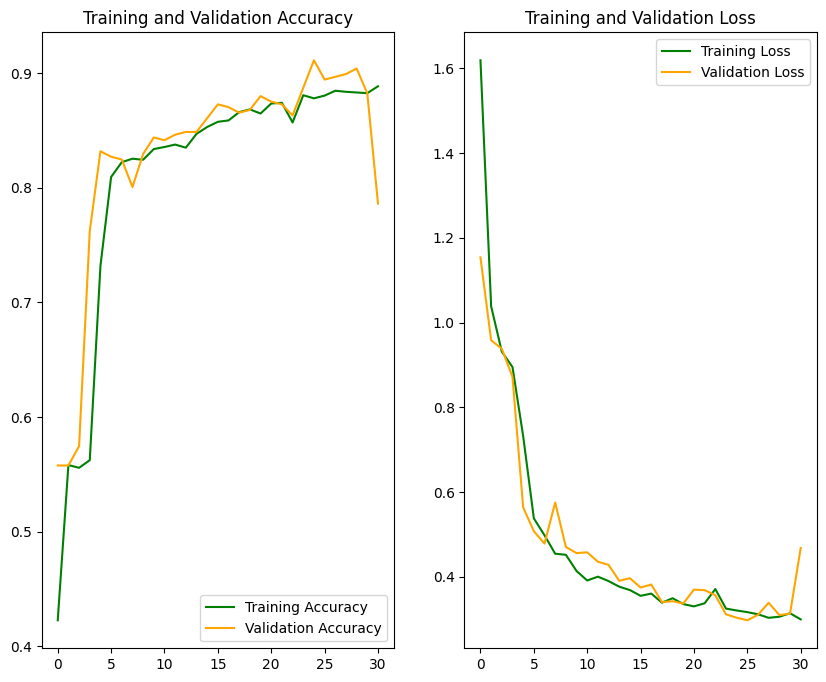

In [23]:
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(range(31), acc, color='green', label='Training Accuracy')
plt.plot(range(31), val_acc, color='orange', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(31), loss, color='green', label='Training Loss')
plt.plot(range(31), val_loss,color='orange', label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
# Function that takes an image as an input
# And gives us the confidence score of the prediction

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 [==============================] - 0s 44ms/step


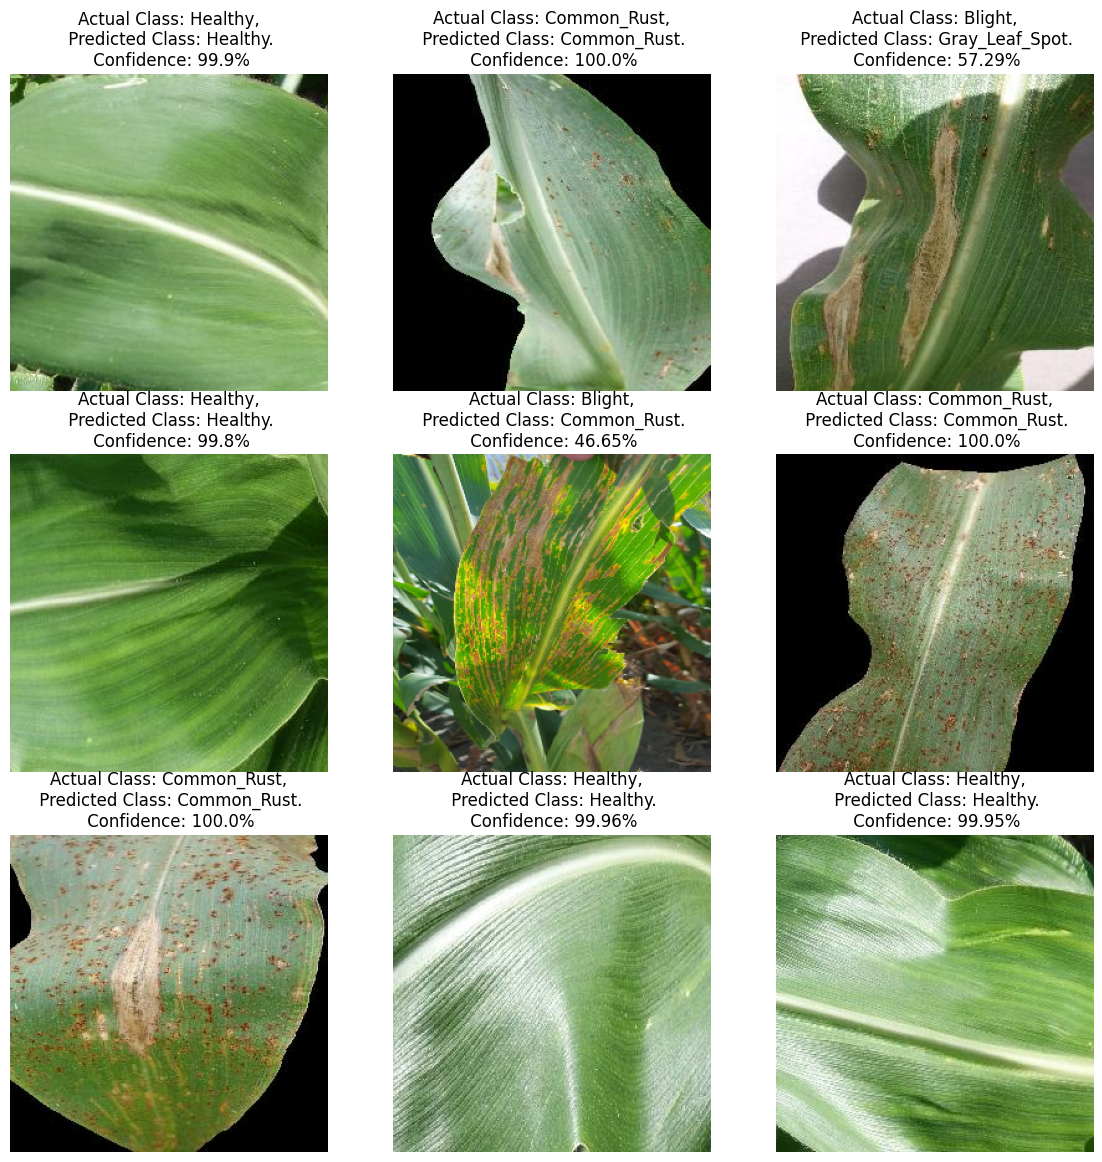

In [27]:
# Let's predict the first 9 images in the first batch
class_names = classes

plt.figure(figsize=(14, 14))
for images, labels in test_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual Class: {actual_class},\n Predicted Class: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
        

In [28]:
model.save(os.path.join('models', 'maize_disease_model.h5'))